In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sparse
import json
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('white')

from bundling3D import *

path2nature = '/Users/ajgates/Documents/DataSets/NatureWeb/'

The main function is hammer_bundle
it requires 2 input DataFrames:
1) node positions where the index of the DataFrame is the node id, and it contains the columns 'x', 'y', 'z'
2) edge list where each edge is an undirected link from 'source' to 'target'


In [3]:
cocitedf = pd.read_csv('/Users/ajgates/Desktop/cociteNodes_NatureID.csv')
cocitedf.drop_duplicates('NatureID', inplace=True)
cocitedf['id'] = cocitedf['NatureID']

cocitedf

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,x,y,size,PubYear,HierCat,NatureID,Title,SortDate,TimeStep,id
0,-2730.00,1220.00,1.50,1869,5,001024a0,The Suez Canal,1869-11-04,-1.0,001024a0
1,380.87,-350.01,1.50,1870,1,003147b0,Is Mimicry Advantageous?,1870-12-22,0.0,003147b0
2,226.53,-821.52,1.50,1871,1,003507a0,Protective Resemblances,1871-04-27,1.0,003507a0
3,11464.99,13076.58,1.50,1871,1,003508a0,Sexual Selection,1871-04-27,2.0,003508a0
4,16508.18,14220.87,1.50,1871,1,004025b0,Pangenesis,1871-05-11,3.0,004025b0
5,-1004.65,-1107.87,7.50,1871,1,005084d0,The Origin of Species,1871-11-30,4.0,005084d0
6,-2727.70,1218.97,1.50,1872,5,005400a0,The Aurora of February 4,1872-03-21,5.0,005400a0
7,-2761.73,1259.31,1.50,1872,5,005443b0,The Aurora of February 4‡,1872-04-04,6.0,005443b0
8,16419.81,14064.29,1.50,1873,1,007281b0,Inherited Instinct,1873-02-13,7.0,007281b0
9,-531.31,4380.81,1.50,1873,8,007303c0,Letters to Editor,1873-02-20,8.0,007303c0


In [4]:
# example running on co-citation network, usually takes about 2-3 hours

cocitedf['z'] = cocitedf['size']*10
cocitedf


cocitedf.set_index('id', inplace=True)


# Calculate min/max for coordinates
xmin, xmax = np.min(cocitedf['x']), np.max(cocitedf['x'])
ymin, ymax = np.min(cocitedf['y']), np.max(cocitedf['y'])
zmin, zmax = np.min(cocitedf['z']), np.max(cocitedf['z'])

# Normalize coordinates
cocitedf['x'] = minmax_normalize(cocitedf['x'], xmin, xmax)
cocitedf['y'] = minmax_normalize(cocitedf['y'], ymin, ymax)
cocitedf['z'] = minmax_normalize(cocitedf['z'], zmin, zmax)
        

cocitedf.head()

,x,y,size,PubYear,HierCat,NatureID,Title,SortDate,TimeStep,z
id,,,,,,,,,,
001024a0,0.082341,0.370533,1.5,1869,5,001024a0,The Suez Canal,1869-11-04,-1.0,0.0
003147b0,0.175926,0.332181,1.5,1870,1,003147b0,Is Mimicry Advantageous?,1870-12-22,0.0,0.0
003507a0,0.171283,0.320663,1.5,1871,1,003507a0,Protective Resemblances,1871-04-27,1.0,0.0
003508a0,0.509372,0.660170,1.5,1871,1,003508a0,Sexual Selection,1871-04-27,2.0,0.0
004025b0,0.661088,0.688123,1.5,1871,1,004025b0,Pangenesis,1871-05-11,3.0,0.0


In [72]:
cociteedges = pd.read_csv('/Users/ajgates/Desktop/cociteEdges.csv')

nature2wos = pd.read_hdf(os.path.join(path2nature, 'aid_wosid.hdf'))
nature2wos['NatureID'] = nature2wos['ArticleID']
nature2wos = nature2wos[['NatureID', 'WOS_ID']]
print(nature2wos.shape)
nature2wos.drop_duplicates('NatureID', inplace=True)
nature2wos.drop_duplicates('WOS_ID', inplace=True)
print(nature2wos.shape)

cociteedges = cociteedges.merge(nature2wos, how='left', left_on='source', right_on='WOS_ID')
del cociteedges['source']
cociteedges['source'] = cociteedges['NatureID']
del cociteedges['NatureID']
del cociteedges['WOS_ID']

cociteedges = cociteedges.merge(nature2wos, how='left', left_on='target', right_on='WOS_ID')
del cociteedges['target']
cociteedges['target'] = cociteedges['NatureID']
del cociteedges['NatureID']
del cociteedges['WOS_ID']

print(cociteedges.shape)
cociteedges.dropna(inplace=True)
print(cociteedges.shape)
cociteedges.head()

(395503, 2)
(222642, 2)
(244809, 2)
(239622, 2)


,source,target
0,207249a0,200413a0
1,207249a0,182202a0
2,207249a0,194201a0
3,207249a0,217837a0
4,207249a0,215612a0


In [5]:
cociteedges = pd.read_csv('/Users/ajgates/Desktop/cociteEdges.csv')

In [6]:
df = pd.merge(cociteedges, cocitedf[['x', 'y', 'z']], left_on=['source'], right_index=True)
df = df.rename(columns={'x': 'src_x', 'y': 'src_y', 'z': 'src_z'})

df = pd.merge(df,  cocitedf[['x', 'y', 'z']], left_on=['target'], right_index=True)
df = df.rename(columns={'x': 'dst_x', 'y': 'dst_y', 'z': 'dst_z'})
df.dropna(inplace=True)
df = df.sort_index()
df = df.reset_index()
print(df.shape)

(244290, 9)


In [7]:
df.head()

,index,source,target,src_x,src_y,src_z,dst_x,dst_y,dst_z
0,0,032342a0,034052a0,0.216647,0.341162,0.000000,0.217273,0.341731,0.000000
1,2,032342a0,157025a0,0.216647,0.341162,0.000000,0.194461,0.342563,0.146011
2,4,034052a0,157025a0,0.217273,0.341731,0.000000,0.194461,0.342563,0.146011
3,11,188226a0,190798a0,0.125240,0.366918,0.093295,0.123495,0.364304,0.061666
4,12,053296d0,237264a0,0.096181,0.314429,0.016232,0.100361,0.319796,0.367415


In [8]:
df['segment_length'] = [distance_between(x[:3], x[3:])  for x in df[['src_x', 'src_y', 'src_z', 'dst_x', 'dst_y', 'dst_z']].values]


df = df[df['segment_length'] > 0]

df[['source', 'target']] = df[['source', 'target']].stack().rank(method='dense').unstack().astype(int)


print(df['segment_length'].min(), df['segment_length'].max(), df['segment_length'].mean())


2.4428310359703165e-05 0.8961864223117804 0.054314644515592675


In [88]:
df.head()

,index,source,target,src_x,src_y,src_z,dst_x,dst_y,dst_z,segment_length
0,0,31727,27335,0.318768,0.537889,0.043956,0.330648,0.549364,0.142857,0.100271
1,1,31727,15980,0.318768,0.537889,0.043956,0.364076,0.601882,0.208791,0.182534
2,2,31727,23465,0.318768,0.537889,0.043956,0.303967,0.451256,0.054945,0.088572
3,3,31727,38269,0.318768,0.537889,0.043956,0.314337,0.525380,0.054945,0.017230
4,4,31727,37028,0.318768,0.537889,0.043956,0.295610,0.534994,0.076923,0.040391


In [10]:
np.percentile(df['segment_length'], 50)

0.031868609783387486

In [11]:
Nnodes = cocitedf.shape[0]

subedges = df['segment_length'] > 0.03

mat = sparse.coo_matrix((np.ones(df.loc[subedges].shape[0], dtype=int), (df.loc[subedges,'source'].values, df.loc[subedges,'target'].values)), shape = (Nnodes, Nnodes))

print(mat.shape)

(88603, 88603)


In [12]:
ncomp, membership = sparse.csgraph.connected_components(mat)

mvalue, mcounts = np.unique(membership, return_counts=True)
mcounts, mcountdist = np.unique(mcounts, return_counts=True)

mcounts, mcountdist

(array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    18,
           19,    20,    21,    22,    23,    24,    25,    26,    27,
           28,    30,    31,    32,    33,    34,    37,    45,    47,
           49,    58,    72, 59554]),
 array([17904,  1544,   604,   266,   157,   104,    56,    38,    34,
           14,    17,    22,    13,    19,     6,     7,     5,     9,
            3,     7,     4,     6,     5,     2,     2,     2,     2,
            1,     2,     1,     1,     1,     1,     2,     1,     1,
            1,     1,     1,     1]))

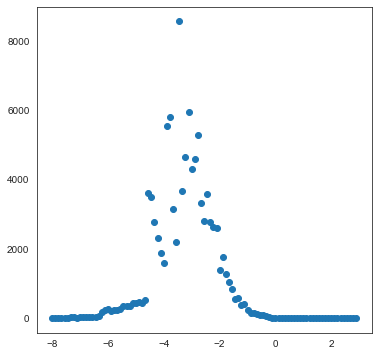

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

dist, bins = np.histogram(df['segment_length'].values, bins=np.exp(np.linspace(-8, 3, 100)))

ax.scatter(np.log(bins[:-1]), dist)

plt.show()

In [32]:
cocite_bundled = hammer_bundle(cocitedf[['x', 'y', 'z']], cociteedges[['source', 'target']], 
                               initial_bandwidth=0.40, 
                               decay = 0.7, 
                               accuracy=5*10**2, 
                              weight = None,
                              advect_iterations=50, iterations=5,
                              min_segment_length=0.001, max_segment_length=0.05)
cocite_bundled.head()

Process Bundling
Start Bundling
Start Smoothing


,x,y,z
0,-1834.000000,529.000000,6.598095
1,-1691.770164,572.085707,5.970600
2,-1552.537463,611.691099,5.404736
3,-1419.330079,645.286174,4.937428
4,-1295.648611,671.008629,4.584232


In [21]:
cocitedf[['x', 'y', 'z']].shape, cociteedges[['source', 'target']].shape

((88623, 3), (244808, 2))

In [ ]:
cociteedges.reset_index(drop=True, inplace=True)

In [14]:
def bundle_between_clusters(nodes, edges, threshold=0.025):
    
    df = pd.merge(edges, nodes[['x', 'y', 'z']], left_on=['source'], right_index=True)
    df = df.rename(columns={'x': 'src_x', 'y': 'src_y', 'z': 'src_z'})

    df = pd.merge(df,  nodes[['x', 'y', 'z']], left_on=['target'], right_index=True)
    df = df.rename(columns={'x': 'dst_x', 'y': 'dst_y', 'z': 'dst_z'})
    df.dropna(inplace=True)
    df = df.sort_index()
    df = df.reset_index()
    
    ptnames = ['src_x', 'src_y', 'src_z', 'dst_x', 'dst_y', 'dst_z']
    
    df['segment_length'] = [distance_between(x[:3], x[3:])  for x in df[ptnames].values]
    
    df = df[df['segment_length'] > 0]

    #df[['source', 'target']] = df[['source', 'target']].stack().rank(method='dense').unstack().astype(int)
    
    edges2bundle = df['segment_length'] > threshold
    
    bundled_edges = hammer_bundle(nodes[['x', 'y', 'z']], df.loc[edges2bundle, ['source', 'target']], 
                               initial_bandwidth=0.40, 
                               decay = 0.7, 
                               accuracy=5*10**2, 
                              weight = None,
                              advect_iterations=50, iterations=5,
                              min_segment_length=threshold/2.0, max_segment_length=0.05)
    
    npts = bundled_edges.shape[0]
    bundled_edge_df = []
    edgepts = []
    iedge = 0
    for irow in range(npts - 1):
        x = bundled_edges.loc[irow].values.flatten()
        
        if np.isnan(x).sum() > 0:
            
            path = '; '.join(map(str, edgepts))
            bundled_edge_df.append([edges.loc[iedge, 'source'], edges.loc[iedge, 'target'], path])
            
            iedge += 1
            edgepts = []

        else:
            edgepts.extend(list(x))
    bundled_edge_df = pd.DataFrame(bundled_edge_df, columns = ['source', 'target', 'path'])
    
    straight_edges = df['segment_length'] <= threshold
    straight_edge_df = df[straight_edges]
    straight_edge_df['path'] =  ['; '.join(map(str, row)) for row in straight_edge_df[ptnames].values]
    straight_edge_df = straight_edge_df[['source', 'target', 'path']]
    
    return pd.concat([bundled_edge_df, straight_edge_df])

edgedf = bundle_between_clusters(cocitedf[['x', 'y', 'z']], cociteedges, threshold=0.025)

edgedf.to_csv('/Users/ajgates/Desktop/cociteEdges2.csv', header=True, index=False)

Process Bundling
Start Bundling
Start Smoothing


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Desktop/cociteEdges2.csv'

In [15]:
edgedf.to_csv('/Users/ajgates/Desktop/cociteEdges2.csv', header=True, index=False)

In [94]:
straight_edges = df['segment_length'] <= 0.025
straight_edge_df = df[straight_edges]
straight_edge_df['path'] = ['; '.join(map(str, row)) for row in straight_edge_df[['src_x', 'src_y', 'src_z', 'dst_x', 'dst_y', 'dst_z']].values]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
